In [2]:
import os
import csv
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

samples = []

# Storing the driving log file in Samples list to use it later.
with open('../data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Shuffle the data and separete 80% for training and 20% for validation        
shuffle(samples)        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print("Data Loaded and separated!")  

Data Loaded and separated!


In [3]:
# Generator
import cv2
import sklearn
import matplotlib.pyplot as plt

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Infinite loop so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # We are now using the 3 images of the camera, left, center and right
                for i in range(3):
                    name = batch_sample[i].split('/')[-1]
                    #center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    center_image = cv2.imread(name)
                    center_angle = float(batch_sample[3])
                    images.append(center_image)
                    images.append(cv2.flip(center_image,1))
                    
                    #Include an angle measurement per each camera and its counter-part(flip)
                    if(i==0):
                        angles.append(center_angle)
                        angles.append(center_angle*-1.0)
                    elif(i==1):
                        angles.append(center_angle+0.2)
                        angles.append((center_angle+0.2)*-1.0)
                    elif(i==2):
                        angles.append(center_angle-0.2)
                        angles.append((center_angle-0.2)*-1.0)        
                            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)
    
# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)  

print("Generator Finished")
    

Generator Finished


In [4]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

#Start model
model = Sequential()

# Pre process each pixel
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# Cropping unwanted part of the image
model.add(Cropping2D(cropping=((70,25),(0,0))))

#1st Convolution
model.add(Conv2D(24, (5,5), strides=(2,2), activation="relu"))

#2nd Convolution
model.add(Conv2D(36, (5,5), strides=(2,2), activation="relu"))

#3rd Convolution
model.add(Conv2D(48, (5,5), strides=(2,2), activation="relu"))

#4thConvolution
model.add(Conv2D(64, (3,3), activation="relu"))

#5th Convolution
model.add(Conv2D(64, (3,3), activation="relu"))

model.add(Flatten())

# 1st Fully connnected layer
model.add(Dense(100))
model.add(Activation("relu"))
# Dropout to prevent overfitting
model.add(Dropout(0.25))

#2nd Fully connected layer
model.add(Dense(50))
model.add(Activation("relu"))

#3erd fully connnected layer
model.add(Dense(10))
model.add(Activation("relu"))

#Final ouput of the regression problem
model.add(Dense(1))


Using TensorFlow backend.


Epoch 1/5
211/210 [==============================] - 412s 2s/step - loss: 0.0345 - val_loss: 0.0284
Epoch 2/5
211/210 [==============================] - 401s 2s/step - loss: 0.0305 - val_loss: 0.0279
Epoch 3/5
211/210 [==============================] - 433s 2s/step - loss: 0.0293 - val_loss: 0.0270
Epoch 4/5
211/210 [==============================] - 446s 2s/step - loss: 0.0285 - val_loss: 0.0269
Epoch 5/5
211/210 [==============================] - 443s 2s/step - loss: 0.0278 - val_loss: 0.0269
dict_keys(['loss', 'val_loss'])


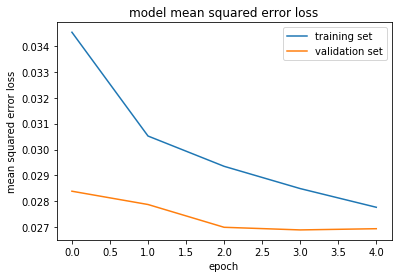

Finished - model saved!


In [5]:
# Use adam optimizer instead of manual tunning of the learning rate.
model.compile(loss='mse', optimizer='adam')

# Save the history of the object to print it later
history_object = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

#Saving model
model.save('model.h5')

print("Finished - model saved!")